S.Leblanc, M.Brunet
<br>06/09/2020

This notebook contains the re-analysis of affinity purification-mass spectrometry experiments to investigate virus protein-host protein interactions with a proteogenomics approach.<br>
The following steps are performed in order:
1. Creation of protein library using RNAseq data
2. MS analysis using tools from Compomics
3. Extract PSMs from MS analysis reports
4. Generate files necessary for MiST
5. Run MiST
6. Compare sets of protein interactions

In [ ]:
from proteogeno.utils import *

## Generate protein library based on transcriptomic data

In [148]:
# dictionary of all OpenProt 1.5 proteins by transcript
enst_trxps = []
all_prots_by_trxp = {}
with open('human-openprot-r1_5-refprots+altprots+isoforms-+uniprot2019_03_01.tsv', 'r') as f:
    for n,l in enumerate(f):
        if l[0]=='#': continue
        ls = l.strip().split('\t')    
        if n==1:
            keys = ls
        line=dict(zip(keys, ls))
        trxp_acc = line['transcript accession'].split('.')[0]
        if 'ENST' not in trxp_acc: continue        
        if trxp_acc not in all_prots_by_trxp:
            all_prots_by_trxp[trxp_acc] = [line['protein accession numbers']]
        else:
            all_prots_by_trxp[trxp_acc].append(line['protein accession numbers'])
        if line['protein type'] != 'RefProt':continue
        uniprot_acc = [x.split('-')[0] for x in line['protein accession (others)'].split(';') if 'ENSP' not in x and '_' not in x]
        if not uniprot_acc: continue
        enst_trxps.append((uniprot_acc[0], trxp_acc))


uniprot_enst_trxps = {}
for prot_acc, trxps in itt.groupby(sorted(enst_trxps), key=lambda x: x[0]):
    uniprot_enst_trxps[prot_acc] = list(set(x[1] for x in trxps))

In [200]:
transcripto_files = {
    'mock' : ['SRR3191542', 'SRR3191543'],
    'zika' : ['SRR3191544', 'SRR3191545']
}

cuff_gtfs = {}
cuff_trxp_fpkms = {}
for exp_id in [x for y in transcripto_files.values() for x in y if type(y)==list]:
    cuff_gtf_path = '/home/xroucou_group/echange_de_fichiers/Zika_Marie_Seb/Results_CuffLinks/{}/transcripts.gtf'.format(exp_id) 
    cuff_gtfs[exp_id] = parse_gtf(cuff_gtf_path)
    cuff_trxp_fpkms[exp_id] = {x['desc']['transcript_id']:x['desc']['FPKM'] for x in cuff_gtfs[exp_id] if x['feature']=='transcript'}

print(len(cuff_trxp_fpkms), list(cuff_trxp_fpkms['SRR3191545'].items())[:3])

4 [('ENST00000417324.1', 0.0), ('ENST00000461467.1', 0.0), ('ENST00000642116.1', 0.0)]


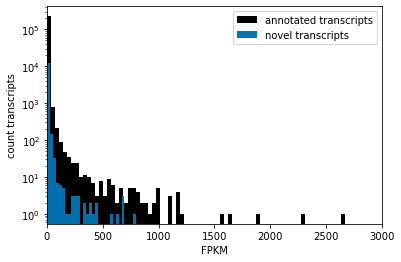

In [201]:
enst_fpkms = [v for k,v in cuff_trxp_fpkms['SRR3191545'].items() if 'CUFF' not in k]
cuff_fpkms = [v for k,v in cuff_trxp_fpkms['SRR3191545'].items() if 'CUFF' in k]

plt.figure(facecolor='w')
plt.hist(enst_fpkms, bins=200, color='k', label='annotated transcripts')
plt.hist(cuff_fpkms, bins=30, color='#0072b2fa', label='novel transcripts')
plt.xlim(0,3000)
plt.yscale('log')
plt.xlabel('FPKM')
plt.ylabel('count transcripts')
plt.legend()
plt.savefig('/home/xroucou_group/echange_de_fichiers/Zika_Marie_Seb/figure_pannels/fpkm_histo.svg')
plt.show()

In [202]:
# Use gffread to extract sequences of cufflink transcripts
for rnaseq_file in ['SRR3191542', 'SRR3191543', 'SRR3191544', 'SRR3191545']:  
    genome_fasta      = '/home/xroucou_group/echange_de_fichiers/Zika_Marie_Seb/GRCh38.primary_assembly.genome.fa'
    gffread_path      = '/home/sleblanc/cufflinks-2.2.1.Linux_x86_64/gffread'
    trxp_fasta_output = '/home/sleblanc/ZIKV_{}_transcripts.fa'.format(rnaseq_file)
    cuff_gtf_path     = '/home/xroucou_group/echange_de_fichiers/Zika_Marie_Seb/Results_CuffLinks/{}/transcripts.gtf'.format(rnaseq_file)
    cmd = '{gffread_path} -w {trxp_fasta_output} -g {genome_fasta} {cuff_gtf_path}'.format(
        genome_fasta=genome_fasta,
        gffread_path=gffread_path,
        cuff_gtf_path=cuff_gtf_path,
        trxp_fasta_output=trxp_fasta_output,
    )

    result = subprocess.run(cmd.split(), stdout=open('{}_gffread_stdout.log'.format(rnaseq_file), 'w'), stderr=open('{}_gffread_stderr.log'.format(rnaseq_file), 'w'))

In [203]:
zikv_custom_trxps = {}
for exp_id in ['SRR3191542', 'SRR3191543', 'SRR3191544', 'SRR3191545']:
    zik_trxp_fasta = SeqIO.parse('/home/sleblanc/ZIKV_{}_transcripts.fa'.format(exp_id), 'fasta')
    coord_dict = {x['desc']['transcript_id'].split('.')[0] if 'ENST' in x['desc']['transcript_id'] else x['desc']['transcript_id']:x for x in cuff_gtfs[exp_id] if x['feature']=='transcript'}
    zikv_custom_trxps[exp_id] = {}
    for trxp in zik_trxp_fasta:
        trxp_acc = trxp.description.split()[0].split('.')[0] if 'ENST' in trxp.description.split()[0] else trxp.description.split()[0]
        gene = trxp.description.split('gene=')[1]
        zikv_custom_trxps[exp_id][trxp_acc] = {
            'gene'     : gene,
            'trxp_seq' : str(trxp.seq),
            'orfs'     : altorfs_3frame(trxp.seq),
            'coord'    : {
                'chrom' : coord_dict[trxp_acc]['chrom'], 
                'start' : int(coord_dict[trxp_acc]['start']), 
                'end'   : int(coord_dict[trxp_acc]['end']),
            },
        }

for exp_id, trxps in zikv_custom_trxps.items():
    trxp_summary = { 
        'count orfs in CUFF trxps':sum([len(v['orfs']) for k,v in trxps.items() if 'CUFF' in k]),
        'count orfs in ENST trxps':sum([len(v['orfs']) for k,v in trxps.items() if 'ENST' in k]),
        'count orfs in all trxps':sum([len(v['orfs']) for k,v in trxps.items()]),
    }
    print(exp_id, trxp_summary)

list(zikv_custom_trxps['SRR3191545'].items())[:3]

SRR3191542 {'count orfs in CUFF trxps': 21012, 'count orfs in ENST trxps': 169550, 'count orfs in all trxps': 190562}
SRR3191543 {'count orfs in CUFF trxps': 20019, 'count orfs in ENST trxps': 169553, 'count orfs in all trxps': 189572}
SRR3191544 {'count orfs in CUFF trxps': 19316, 'count orfs in ENST trxps': 169559, 'count orfs in all trxps': 188875}
SRR3191545 {'count orfs in CUFF trxps': 20179, 'count orfs in ENST trxps': 169558, 'count orfs in all trxps': 189737}


[('ENST00000456328',
  {'gene': 'CUFF.24',
   'trxp_seq': 'GTTAACTTGCCGTCAGCCTTTTCTTTGACCTCTTCTTTCTGTTCATGTGTATTTGCTGTCTCTTAGCCCAGACTTCCCGTGTCCTTTCCACCGGGCCTTTGAGAGGTCACAGGGTCTTGATGCTGTGGTCTTCATCTGCAGGTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGGTGCAAGCTGAGCACTGGAGTGGAGTTTTCCTGTGGAGAGGAGCCATGCCTAGAGTGGGATGGGCCATTGTTCATCTTCTGGCCCCTGTTGTCTGCATGTAACTTAATACCACAACCAGGCATAGGGGAAAGATTGGAGGAAAGATGAGTGAGAGCATCAACTTCTCTCACAACCTAGGCCAGTGTGTGGTGATGCCAGGCATGCCCTTCCCCAGCATCAGGTCTCCAGAGCTGCAGAAGACGACGGCCGACTTGGATCACACTCTTGTGAGTGTCCCCAGTGTTGCAGAGGCAGGGCCATCAGGCACCAAAGGGATTCTGCCAGCATAGTGCTCCTGGACCAGTGATACACCCGGCACCCTGTCCTGGACACGCTGTTGGCCTGGATCTGAGCCCTGGTGGAGGTCAAAGCCACCTTTGGTTCTGCCATTGCTGCTGTGTGGAAGTTCACTCCTGCCTTTTCCTTTCCCTAGAGCCTCCACCACCCCGAGATCACATTTCTCACTGCCTTTTGTCTGCCCAGTTTCACCAGAAGTAGGCCTCTTCCTGACAGGCAGCTGCACCACTGCCTGGCGCTGTGCCCTTCCTTTGCTCTGCCCGCTGGAGACGGTGTTTGTCATGGGCCTGGTCTGCAGGGATCCTGCTACAAAGGTGAAACCCAGGAGAGTGTGGAGTCCAGAGTGTTGCCAGGACCCAGGCACAGGCATTAGTGCCCGTTGGAGAAAACAGGGGAATCCCGAAGAAATGGTGGGTCCTGGCCATCC

In [204]:
cuff_trxp_by_reps = {}
trxp_seq_to_acc   = {}
for mock_zika in ['mock', 'zika']:
    cuff_trxp_by_reps[mock_zika] = {'combined_reps':[], }
    trxp_seq_to_acc[mock_zika] = {}
    for exp_id in transcripto_files[mock_zika]:
        cuff_trxp_by_reps[mock_zika][exp_id] = list(set(v['trxp_seq'] for k,v in zikv_custom_trxps[exp_id].items() if 'CUFF' in k))
        cuff_trxp_by_reps[mock_zika]['combined_reps'].extend(cuff_trxp_by_reps[mock_zika][exp_id])
        trxp_seq_to_acc[mock_zika][exp_id] = {v['trxp_seq']:k for k,v in zikv_custom_trxps[exp_id].items() if 'CUFF' in k}

cuff_trxps = {}
rep_trxp_accs = {}
for mock_zika in ['mock', 'zika']:
    cuff_trxps[mock_zika] = {}
    rep_trxp_accs[mock_zika] = {}
    count_cuff_reps = Counter(cuff_trxp_by_reps[mock_zika]['combined_reps'])
    cuff_trxps_in_both_reps = [k for k,v in count_cuff_reps.items() if v>1]
    for n, trxp_seq in enumerate(cuff_trxps_in_both_reps):
        trxp_accs_fkpm = {
            trxp_seq_to_acc[mock_zika][exp_id][trxp_seq]: cuff_trxp_fpkms[exp_id][trxp_seq_to_acc[mock_zika][exp_id][trxp_seq]] 
            for exp_id in transcripto_files[mock_zika]
        }
        
        trxp_acc = 'CUFF_' + mock_zika + '_tx' + '0'*(4-len(str(n))) + str(n)
        rep_trxp_accs[mock_zika][trxp_acc] = tuple(trxp_accs_fkpm.keys())
        cuff_trxps[mock_zika][trxp_acc] = {'orfs':altorfs_3frame(trxp_seq), 'fpkm':np.mean(list(trxp_accs_fkpm.values()))}

for trxp_comb_acc, high_cuff_trxp in sorted(cuff_trxps['zika'].items(), key=lambda x: -1*x[1]['fpkm'])[:10]:
    trxp_acc1, trxp_acc2 = rep_trxp_accs['zika'][trxp_comb_acc]
    if trxp_acc1 in zikv_custom_trxps[transcripto_files['zika'][0]]:
        coord = tuple(zikv_custom_trxps[transcripto_files['zika'][0]][trxp_acc1]['coord'][x] for x in ['chrom', 'start', 'end'])
    else:
        coord = tuple(zikv_custom_trxps[transcripto_files['zika'][1]][trxp_acc1]['coord'][x] for x in ['chrom', 'start', 'end'])
    print(coord)

('chr5', 147390808, 147454266)
('chr1', 1785285, 1832285)
('chr1', 1785285, 1890401)
('chr3', 149964904, 149970401)
('chr7', 73440406, 73522293)
('chr8', 30785616, 30812878)
('chr8', 116845935, 116874528)
('chr1', 52020131, 52024656)
('chr3', 133805615, 133821492)
('chr1', 51354263, 51422104)


In [205]:
# average transcript abundance (FPKMs) across duplicates
transcripto_zika = []
for exp_id in transcripto_files['zika']:
    transcripto_zika.extend([(x['desc']['transcript_id'], x['desc']['FPKM']) for x in cuff_gtfs[exp_id] if x['feature']=='transcript'])
        
lone_trxp = []
zika_trxps = []
for trxp, fpkms in itt.groupby(sorted(transcripto_zika), key=lambda x: x[0]):
    if 'CUFF' in trxp: continue
    trxp = trxp.split('.')[0]
    fpkms = [x[1] for x in fpkms]
    if len(fpkms) > 2:
        print('error')
        break
    if len(fpkms)==1:
        lone_trxp.append((exp_id, trxp, fpkms[0]))
    zika_trxps.append((trxp, np.mean(fpkms)))

In [211]:
zika_trxp_fpkm = dict(zika_trxps)
zikv_ctrl_metrics = []
with open('ZIKV_ctrl_metrics.out', 'r') as f:
    for n,l in enumerate(f):
        ls = l.strip().split('\t')
        if n==0:
            keys = ls
            continue
        line = dict(zip(keys, ls))
        line['mist_score'] = 0.
        for k in ['Reproducibility', 'Abundance', 'Specificity']:
            line[k] = float(line[k])
            line['mist_score'] += line[k]*ctrl_weights[k]
        zikv_ctrl_metrics.append(line)

In [212]:
zikv_ctrl_preys = set(x['Prey'] for x in zikv_ctrl_metrics)
print(len(zikv_ctrl_preys), list(zikv_ctrl_preys)[:5])

2486 ['Q9H871', 'O75027', 'Q5VT06', 'P62277', 'Q9NV31']


In [213]:
# trxps from ctrl run (only trxps associated with prots from uniprot run)
crtl_trxps = []
for p in zikv_ctrl_preys:
    if p in uniprot_enst_trxps:
        trxps = uniprot_enst_trxps[p]
        for trxp in trxps:
            fpkm = 0
            if trxp in zika_trxp_fpkm:
                fpkm = zika_trxp_fpkm[trxp]
            crtl_trxps.append((p, trxp, fpkm))
    
print(len(crtl_trxps), crtl_trxps[:5])

crtl_trxps_set = set(x[1] for x in crtl_trxps)
print('unique trxps:', len(crtl_trxps_set), list(crtl_trxps_set)[:5])

6080 [('Q9H871', 'ENST00000283632', 20.4105881459), ('O75027', 'ENST00000339447', 2.70998288775), ('O75027', 'ENST00000645829', 1.8349249984), ('O75027', 'ENST00000253577', 0.0), ('O75027', 'ENST00000373394', 0.4764343593)]
unique trxps: 6079 ['ENST00000307301', 'ENST00000369905', 'ENST00000361915', 'ENST00000392088', 'ENST00000395245']


In [214]:
# db size per fpkm thershold
n_recovered_prots, n_wt_prots, n_cuff_prots = [], [], []
n_ctrl_prot = len(set(x[0] for x in crtl_trxps))
fpkm_thresh_range = np.logspace(-5, 5, 200)
for fpkm_thresh in fpkm_thresh_range:
    passing_trxps = set(x[0] for x in zika_trxps if x[1]>=fpkm_thresh)
    n_recovered_prots.append(len(set(x[0] for x in crtl_trxps if x[2]>=fpkm_thresh))/n_ctrl_prot)
    n_wt_prots.append(sum([len(all_prots_by_trxp[x]) for x in passing_trxps if x in all_prots_by_trxp]))
    n_cuff_prots.append(sum(len(v['orfs']) for v in cuff_trxps['zika'].values() if v['fpkm']>=fpkm_thresh))

In [215]:
def get_OP_fpkm_filtered(fpkm_thresh):
    passing_trxps = set(x[0] for x in zika_trxps if x[1]>=fpkm_thresh)
    custom_fasta = []
    for seq in SeqIO.parse('human-openprot-r1_5-refprots+altprots+isoforms-+uniprot2019_03_01.fasta', 'fasta'):
        if 'ENST' in seq.description:
            header = parse_fasta_header(seq.description)
            TAs = [t.split('.')[0] for t in header['TA'].split(',')] # removed version
            if any(TA in passing_trxps for TA in TAs):
                custom_fasta.append({
                    'desc':seq.description,
                    'seq' :str(seq.seq)
                })
                
    return custom_fasta

In [218]:
rescue_prots = set(x[0] for x in crtl_trxps if x[2]<=fpkm_thresh).intersection(shah_all_preys)
len(rescue_prots)

1736

In [219]:
def generate_custom_db(fpkm_thresh, return_counts_only=False, return_counts_prot_len=False):
    if return_counts_prot_len:
        orf_len_dist = {'ref':[],'IP_':[],'II_':[], 'cuff_prot':[]}
        counts = {'alt':0, 'iso':0, 'ref':0, 'cuff':0}
    inserted_seqs = set()
    db_entries = [] # [(desc,seq), ...]
    custom_fasta = get_OP_fpkm_filtered(fpkm_thresh)
    
    # CUFF
    cuff_prots = {}
    n_cuff_prots = 0
    for trxp, trxp_attr in cuff_trxps['zika'].items():
        if trxp_attr['fpkm'] < fpkm_thresh: continue
        for prot_seq in trxp_attr['orfs']:
            if prot_seq in OP15_all_protseqs and prot_seq not in inserted_seqs:
                desc = OP15_all_protseqs[prot_seq]
                if return_counts_prot_len:
                    if 'IP_' in desc:
                        orf_len_dist['IP_'].append(len(prot_seq))
                        counts['alt'] += 1
                    elif 'II_' in desc:
                        orf_len_dist['II_'].append(len(prot_seq))
                        counts['iso'] += 1
                    else:
                        orf_len_dist['ref'].append(len(prot_seq))
                        counts['ref'] += 1
                    
                desc = '>' + desc + '\n'
                db_entries.append((desc, prot_seq))
                inserted_seqs.add(prot_seq)
                continue
            if prot_seq in inserted_seqs: continue
            if return_counts_prot_len:
                orf_len_dist['cuff_prot'].append(len(prot_seq))
                counts['cuff'] += 1
            n_cuff_prots += 1
            acc = '{}_ORF{}'.format(trxp, n_cuff_prots)
            cuff_prots[acc] = prot_seq
            desc = '>{}|GN={}\n'.format(acc, 'CUFF_gene')
            db_entries.append((desc, prot_seq))
            inserted_seqs.add(prot_seq)
    
    custom_fasta_seqs = set(x['seq'] for x in custom_fasta)
    n_uniprot_prots = 0
    uniprot_prots = set()
    for n, prot in enumerate(SeqIO.parse('swissprot_UP000005640.fasta', 'fasta')):
        if prot.seq in custom_fasta_seqs and prot.seq not in inserted_seqs:
            prot_acc = prot.description.split('|')[1]
            uniprot_prots.add(prot_acc)
            if return_counts_prot_len:
                orf_len_dist['ref'].append(len(prot.seq))
                counts['ref'] += 1
            desc = prot.description.replace('>sp|', '>')
            desc = '>'+desc+'\n'
            db_entries.append((desc, prot.seq))
            inserted_seqs.add(prot.seq)
            n_uniprot_prots += 1


    # REF (ENST) & alts & iso
    for head_seq in custom_fasta:
        desc = head_seq['desc']
        prot_seq  = head_seq['seq']
        if any(tt_type_prefix in desc for tt_type_prefix in ['IP_', 'II_']):
            if prot_seq in inserted_seqs:
                continue
            if return_counts_prot_len:
                if 'IP_' in desc:
                    orf_len_dist['IP_'].append(len(prot_seq))
                    counts['alt'] += 1
                elif 'II_' in desc:
                    orf_len_dist['II_'].append(len(prot_seq))
                    counts['iso'] += 1
                else:
                    orf_len_dist['ref'].append(len(prot_seq))
                    counts['ref'] += 1

            desc = '>'+desc+'\n'
            db_entries.append((desc, prot_seq))
            inserted_seqs.add(prot_seq)

        elif prot_seq not in inserted_seqs:
            if return_counts_prot_len:
                orf_len_dist['ref'].append(len(prot_seq))
                counts['ref'] += 1
            desc = '>'+desc+'\n'
            db_entries.append((desc, prot_seq))        
            inserted_seqs.add(prot_seq)

    # ZIKV proteins
    sup7 = pyexcel.load('NIHMS1515954-supplement-7.xlsx')
    keys = sup7.array[1]
    n_ZIKV_prots = 0
    for l in sup7.array[2:]:
        line = dict(zip(keys, l))
        if 'ZIKVug' in line['Bait']:
            n_ZIKV_prots += 1
            strain, prot_acc = line['Bait'].split()
            desc = '>zk|{}|{}\n'.format(prot_acc, strain)
            seq = line['Protein Sequence'][:-1] + '\n'
            db_entries.append((desc, seq))               
            inserted_seqs.add(line['Protein Sequence'][:-1])
            
    ret_dict = {}
    if return_counts_only:
        ret_dict['total_prot_count'] = len(db_entries)
        ret_dict['recovered_uniprot'] = len(set.intersection(uniprot_prots, uniprot_run_preys))/ len(uniprot_run_preys)
    else:
        ret_dict = {'lib':db_entries, }
    
    if return_counts_prot_len:
        ret_dict['counts'] = counts
        ret_dict['prot_len_dists'] = orf_len_dist
        ret_dict['recovered_uniprot'] = len(set.intersection(uniprot_prots, uniprot_run_preys))/ len(uniprot_run_preys)
        
    return ret_dict

In [ ]:
uniprot_run_preys = set(x[0] for x in crtl_trxps)
fpkm_thresh_range = np.logspace(-5, 5, 200)
args = zip(fpkm_thresh_range, [True,]*len(fpkm_thresh_range))
with Pool(10) as p:
    prot_counts = p.starmap(generate_custom_db, args)

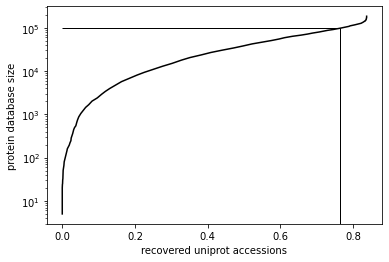

In [221]:
recovered_uniprot = [x['recovered_uniprot'] for x in prot_counts]
total_prot_count = [x['total_prot_count'] for x in prot_counts]

plt.plot(recovered_uniprot, total_prot_count, c='k')
plt.xlabel('recovered uniprot accessions')
plt.ylabel('protein database size')
plt.yscale('log')
plt.hlines(98503, 0, 0.765356, linewidth=1)
plt.vlines(0.765356, 0, 98503, linewidth=1)
plt.savefig('/home/xroucou_group/echange_de_fichiers/Zika_Marie_Seb/figure_pannels/fpkm_plot.svg')
plt.show()

In [222]:
pd.DataFrame([x for x in zip(fpkm_thresh_range, total_prot_count, recovered_uniprot) if x[1]<1e5], columns=['FPKM_thresh', 'n_orfs', 'recovered_uniprot'])

,FPKM_thresh,n_orfs,recovered_uniprot
0,1.499268,98503,0.765356
1,1.683180,94933,0.755528
2,1.889652,91471,0.744881
3,2.121452,87668,0.730139
4,2.381686,83914,0.718264
5,2.673842,80251,0.706798
6,3.001836,75825,0.688780
7,3.370064,71901,0.674857
8,3.783463,67934,0.656839
9,4.247572,63810,0.633088


In [105]:
cust_lib = generate_custom_db(1.499268, return_counts_prot_len=True)

/home/sleblanc/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:175: BiopythonWarning: Biopython Seq objects now use string comparison. Older versions of Biopython used object comparison. During this transition, please use hash(id(my_seq)) or my_dict[id(my_seq)] if you want the old behaviour, or use hash(str(my_seq)) or my_dict[str(my_seq)] for the new string hashing behaviour.
  "the new string hashing behaviour.", BiopythonWarning)


In [109]:
def write_custom_lib(lib, fpath):
    with open(fpath, 'w') as f:
        for desc, seq in lib:
            f.write(desc)
            f.write(truncate(str(seq))+'\n')

In [110]:
write_custom_lib(cust_lib['lib'], 'zika_OP15_RNAseq_custom.fasta')

In [111]:
# Sanity check number of entries in custom fasta
n_orfs = 0
with open('zika_OP15_RNAseq_custom.fasta', 'r') as f:
    for l in f:
        if '>' in l:
            n_orfs += 1
print('total:', n_orfs)

total: 98503


In [112]:
unprot_set = set()
n_uniprot, n_refseq, n_ensmbl, n_ip, n_ii, n_cuff = 0, 0, 0, 0, 0, 0
for seq in SeqIO.parse('zika_OP15_RNAseq_custom.fasta', 'fasta'):
    if 'IP_' in seq.name and 'sp' not in seq.name:
        if seq.description[:3] != 'IP_':
            print(seq.name, seq.description)
        n_ip += 1
        continue
    if 'II_' in seq.name  and 'sp' not in seq.name:
        n_ii += 1
        continue
    if 'CUFF' in seq.name  and 'sp' not in seq.name:
        n_cuff += 1
        continue
    if 'ENSP' in seq.name:
        n_ensmbl += 1
        continue
    if 'XP_' in seq.name or 'NP_' in seq.name:
        n_refseq += 1
        continue
    n_uniprot += 1
    name = seq.name.replace('sp|', ''). split('|')[0]
    unprot_set.add(name)
    
print('cnt uniprot:', n_uniprot)
print('cnt ensembl:', n_ensmbl)
print('cnt refseq:', n_refseq)
total_ref = sum([n_uniprot, n_ensmbl, n_refseq])
print('total refs:', total_ref)
print('cnt ip:', n_ip)
print('cnt ii:', n_ii)
print('cnt cuff:', n_cuff)

print('total alts:', sum([n_ip, n_ii, n_cuff]))
print('total:', sum([n_ip, n_ii, n_cuff, n_uniprot, n_ensmbl, n_refseq]))

cnt uniprot: 13041
cnt ensembl: 83
cnt refseq: 318
total refs: 13442
cnt ip: 80573
cnt ii: 4469
cnt cuff: 19
total alts: 85061
total: 98503


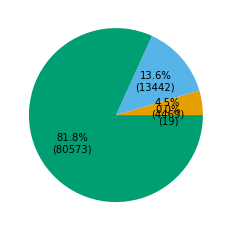

In [129]:
def label_pie(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

color_palette=("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

fig, ax = plt.subplots(facecolor='w')
data = [n_ip, total_ref, n_ii, n_cuff]
ax.pie(sorted(data), autopct=lambda pct: label_pie(pct, data), colors=color_palette)
plt.savefig('/home/xroucou_group/echange_de_fichiers/Zika_Marie_Seb/figure_pannels/proteogeno_lib_piechart.svg')
plt.show()

In [151]:
orf_len_dist = {'ref':[],'alt':[],'iso':[],'zika':[]}
for seq in SeqIO.parse('zika_OP15_RNAseq_custom.fasta', 'fasta'):
    tt_type = get_tt_type(seq.name)
    orf_len_dist[tt_type].append(len(seq.seq))

In [155]:
for tt_type, lens in orf_len_dist.items():
    print(tt_type, 'mean:', np.round(np.mean(lens), 3), 'median:', np.median(lens))

ref mean: 570.742 median: 429.0
alt mean: 54.084 median: 44.0
iso mean: 181.236 median: 86.0
zika mean: 300.684 median: 145.0


/home/sleblanc/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


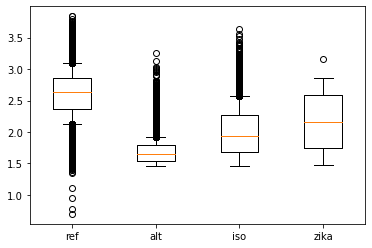

/home/sleblanc/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


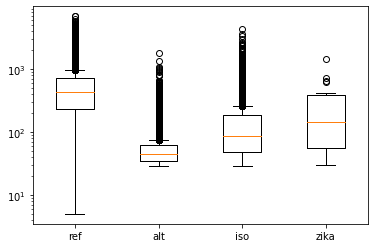

In [153]:
fig, ax = plt.subplots(facecolor='w')

ax.boxplot([np.log10(x) for x in orf_len_dist.values()], notch=False, whis=0.5)
ax.set_xticklabels(orf_len_dist.keys())
plt.savefig('/home/xroucou_group/echange_de_fichiers/Zika_Marie_Seb/figure_pannels/proteogeno_protlen_dist.svg')
plt.savefig('ZIKV_figures/proteogeno_protlen_dist.svg')
plt.show()

fig, ax = plt.subplots(facecolor='w')
ax.boxplot(list(orf_len_dist.values()), notch=False,whis=0.5, )
ax.set_yscale('log')
ax.set_xticklabels(orf_len_dist.keys())
plt.savefig('/home/xroucou_group/echange_de_fichiers/Zika_Marie_Seb/figure_pannels/proteogeno_protlen_scale.svg')
plt.savefig('ZIKV_figures/proteogeno_protlen_scale.svg')
plt.show()

Boxes represent the inter quartile range (IQR) notched at the median and the whiskers are set at 0.5*IQR over and under the 25th and 75th percentiles.

In [116]:
tot_cnt_prot = sum(len(x)for x in orf_len_dist.values())
db_prop = []
for k,v in orf_len_dist.items():
    db_prop.append((k, len(v)))
    print(k, len(v), len(v)/tot_cnt_prot)
db_prop = sorted(db_prop, key=lambda x: x[1])

ref 229432 0.77886296435858
IP_ 60775 0.20631558221561377
II_ 3866 0.013124081297335465
zika 500 0.0016973721284707017


## Run MS analysis with SearchGUI PeptideShaker

In [143]:
# Swissprot run
S = Slurm('ZIKV_ctrl', '/home/sleblanc/slurm_scripts/', '/home/sleblanc/zika_sg_ps/control/', slurm_kwargs={'mem-per-cpu':'8G', 'time':'12:00:00'})
S.get_file_list('/home/sleblanc/zika_mgf/', 'mgf')

commands = [
    'cd $SLURM_TMPDIR',
    'module load java',
    'FILE=$(sed -n "${SLURM_ARRAY_TASK_ID}p" input_file)',
    'EXP=${FILE%.mgf}',
    'echo "file: "$FILE',
    'mkdir tools',
    'cp -r /home/xroucou_group/tools/compomics ./tools/',
    'cp -r /home/sleblanc/pycompomics .',
    'mkdir data',
    'cp /home/sleblanc/ZIKV_swissprot.fasta ./data/ZIKV_swissprot.fasta',
    'cp /home/sleblanc/ZIKV_swissprot_concatenated_target_decoy.fasta ./data/ZIKV_swissprot_concatenated_target_decoy.fasta',
    'cp /home/sleblanc/zika_mgf/$FILE ./data/$FILE',
    'mkdir $EXP',
    'python3 pycompomics/pycompomics/ms_analyze_slurm.py analyze \
    --mgf_file data/$FILE \
    --output_dir $EXP \
    --protein_fdr 1.0 \
    --fasta_db data/ZIKV_swissprot.fasta',
    'rsync -av $EXP /home/sleblanc/zika_sg_ps/control/',
]

S.write_sh_script(commands)
%cat /nfs3_ib/ip32-ib/home/sleblanc/slurm_scripts/ZIKV_ctrl.sh

#!/bin/bash

#SBATCH --account=def-xroucou
#SBATCH --time=12:00:00
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=8G
#SBATCH --array=1-21

cd $SLURM_TMPDIR
module load java
FILE=$(sed -n "${SLURM_ARRAY_TASK_ID}p" /nfs3_ib/ip32-ib/home/sleblanc/zika_mgf/files_list.txt)
EXP=${FILE%.mgf}
echo "file: "$FILE
mkdir tools
cp -r /nfs3_ib/ip32-ib/home/xroucou_group/tools/compomics ./tools/
cp -r /nfs3_ib/ip32-ib/home/sleblanc/pycompomics .
mkdir data
cp /nfs3_ib/ip32-ib/home/sleblanc/ZIKV_swissprot.fasta ./data/ZIKV_swissprot.fasta
cp /nfs3_ib/ip32-ib/home/sleblanc/ZIKV_swissprot_concatenated_target_decoy.fasta ./data/ZIKV_swissprot_concatenated_target_decoy.fasta
cp /nfs3_ib/ip32-ib/home/sleblanc/zika_mgf/$FILE ./data/$FILE
mkdir $EXP
python3 pycompomics/pycompomics/ms_analyze_slurm.py analyze     --mgf_file data/$FILE     --output_dir $EXP     --protein_fdr 1.0     --fasta_db data/ZIKV_swissprot.fasta
rsync -av $EXP /nfs3_ib/ip32-ib/home/sleblanc/zika_sg_ps/control/


In [145]:
S.run(commands)

b'Submitted batch job 5835094'


In [212]:
!java -cp /home/xroucou_group/tools/compomics/SearchGUI-3.3.17/SearchGUI-3.3.17.jar eu.isas.searchgui.cmd.FastaCLI -in /home/sleblanc/zika_OP15_RNAseq_custom.fasta -decoy 

An error occurred when setting path configuration. Default paths will be used.
Reindexing: zika_OP15_RNAseq_custom.fasta.
10% 20% 30% 40% 50% 60% 70% 80% 90%Input: /home/sleblanc/zika_OP15_RNAseq_custom.fasta

Name: zika_OP15_RNAseq_custom
Version: 9.9.2020
Decoy Tag: null
Type: Generic_Header
Last modified: Wed Sep 09 20:28:22 EDT 2020
Size: 98503 sequences


Wed Sep 09 20:29:28 EDT 2020 Appending Decoy Sequences. Please Wait...
10% 20% 30% 40% 50% 60% 70% 80% 90% 100%Reindexing: zika_OP15_RNAseq_custom_concatenated_target_decoy.fasta.

10% 20% 30% 40% 50% 60% 70% 80% 90%Decoy file successfully created: 

Output: /home/sleblanc/zika_OP15_RNAseq_custom_concatenated_target_decoy.fasta

Name: zika_OP15_RNAseq_custom_concatenated_target_decoy
Version: 9.9.2020
Decoy Tag: REVERSED
Type: Generic_Header
Last modified: Wed Sep 09 20:29:37 EDT 2020
Size: 197006 sequences (98503 target)



In [572]:
S = Slurm('ZIKV_custom', '/home/sleblanc/slurm_scripts/', '/home/sleblanc/zika_sg_ps/customlib/', slurm_kwargs={'mem-per-cpu':'8G', 'time':'12:00:00'})
S.get_file_list('/home/sleblanc/zika_mgf/', 'mgf')

commands = [
    'cd $SLURM_TMPDIR',
    'module load java',
    'FILE=$(sed -n "${SLURM_ARRAY_TASK_ID}p" input_file)',
    'EXP=${FILE%.mgf}',
    'echo "file: "$FILE',
    'mkdir tools',
    'cp -r /home/xroucou_group/tools/compomics ./tools/',
    'cp -r /home/sleblanc/pycompomics .',
    'mkdir data',
    'cp /home/sleblanc/zika_OP15_RNAseq_custom.fasta ./data/zika_OP15_RNAseq_custom.fasta',
    'cp /home/sleblanc/zika_OP15_RNAseq_custom_concatenated_target_decoy.fasta ./data/zika_OP15_RNAseq_custom_concatenated_target_decoy.fasta',
    'cp /home/sleblanc/zika_mgf/$FILE ./data/$FILE',
    'mkdir $EXP',
    'python3 pycompomics/pycompomics/ms_analyze_slurm.py analyze \
    --mgf_file data/$FILE \
    --output_dir $EXP \
    --protein_fdr 1.0 \
    --fasta_db data/zika_OP15_RNAseq_custom.fasta',
    'rsync -av $EXP /home/sleblanc/zika_sg_ps/customlib/',
]

S.write_sh_script(commands)
%cat /home/sleblanc/slurm_scripts/ZIKV_custom.sh

#!/bin/bash

#SBATCH --account=def-xroucou
#SBATCH --time=12:00:00
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=8G
#SBATCH --array=1-21

cd $SLURM_TMPDIR
module load java
FILE=$(sed -n "${SLURM_ARRAY_TASK_ID}p" /nfs3_ib/ip32-ib/home/sleblanc/zika_mgf/files_list.txt)
EXP=${FILE%.mgf}
echo "file: "$FILE
mkdir tools
cp -r /nfs3_ib/ip32-ib/home/xroucou_group/tools/compomics ./tools/
cp -r /nfs3_ib/ip32-ib/home/sleblanc/pycompomics .
mkdir data
cp /nfs3_ib/ip32-ib/home/sleblanc/zika_OP15_RNAseq_custom.fasta ./data/zika_OP15_RNAseq_custom.fasta
cp /nfs3_ib/ip32-ib/home/sleblanc/zika_OP15_RNAseq_custom_concatenated_target_decoy.fasta ./data/zika_OP15_RNAseq_custom_concatenated_target_decoy.fasta
cp /nfs3_ib/ip32-ib/home/sleblanc/zika_mgf/$FILE ./data/$FILE
mkdir $EXP
python3 pycompomics/pycompomics/ms_analyze_slurm.py analyze     --mgf_file data/$FILE     --output_dir $EXP     --protein_fdr 1.0     --fasta_db data/zika_OP15_RNAseq_custom.fasta
rsync -av $EXP /nfs3_ib/ip32-ib/home/sleblanc/zika_sg

In [573]:
S.run(commands)

b'Submitted batch job 5897760'


In [592]:
%cat zika_sg_ps/customlib/slurm-5897760_1.out


The following have been reloaded with a version change:
  1) java/1.8.0_192 => java/13.0.1

file: qx004064.mgf
Processing data/qx004064.mgf
Setting search params...
data/zika_OP15_RNAseq_custom_concatenated_target_decoy.fasta
True
b'Path configuration completed.\nReindexing: zika_OP15_RNAseq_custom_concatenated_target_decoy.fasta.\n\nIdentification parameters file created: /localscratch/sleblanc.5897761.0/qx004064/id_params.par\n\n'
b'WARNING: An illegal reflective access operation has occurred\nWARNING: Illegal reflective access by com.google.gson.internal.bind.ReflectiveTypeAdapterFactory (file:/localscratch/sleblanc.5897761.0/tools/compomics/SearchGUI-3.3.17/lib/gson-2.4.jar) to field java.awt.Color.value\nWARNING: Please consider reporting this to the maintainers of com.google.gson.internal.bind.ReflectiveTypeAdapterFactory\nWARNING: Use --illegal-access=warn to enable warnings of further illegal reflective access operations\nWARNING: All illegal access operations will be denied i

## Parse reports of peptides-spectra matches 

In [151]:
exp_report_paths = {'control':{}, 'customlib':{}} # "control" here is SwissProt library
search_path = '/home/sleblanc/zika_sg_ps/'
for lib in exp_report_paths:
    for dirpath, subdirs, files in os.walk(os.path.join(search_path, lib)):
        for f in files:
            if 'Default_Hierarchical_Report' in f:
                exp_id = f.split('_')[0]
                exp_report_paths[lib][exp_id] = os.path.join(dirpath, f)

In [152]:
# Parse key file from raw data
zikv_baits = ['Capsid', 'NS4A', 'NS5', 'NS3', 'NS2B3']
uganda_files = []
zikv_bait_files, bait_rep_dict = {}, {}
with open('zika_raw/experiment.csv', 'r') as f:
    for n,l in enumerate(f):
        if n<13:continue
        ls = l.strip().split('", "')
        try:
            fname, treatment = ls
            if 'Uganda' in treatment:
                uganda_files.append(fname[1:])
                t = treatment.split(', ')
                bait_name = t[2].replace('"', '')
                if 'S135A' in bait_name:
                    continue
                zikv_bait_files[fname[1:].replace('.raw', '')] = t[2]
                if t[2] not in bait_rep_dict:
                    bait_rep_dict[t[2]] = [fname[1:].replace('.raw', '')]
                else:
                    bait_rep_dict[t[2]].append(fname[1:].replace('.raw', ''))
        except:
            continue

rep_bait_dict = {}
for bait, exps in bait_rep_dict.items():
    for exp in exps:
        rep_bait_dict[exp] = bait

In [153]:
# Load interactions from Shah et al supplementary data
sup10 = pyexcel.load('NIHMS1515954-supplement-10.xlsx')
shah_net = set()
shah_all_preys = set()
shah_unfiltered = set()
for n,x in enumerate(sup10):
    if n==0:continue
    if n==1:
        keys = x
        continue
    line = dict(zip(keys, x))
    bait = line['Bait'].replace('ZIKVug ', '')
    if 'ZIKVug' in line['Bait']:
        shah_all_preys.add(line['Prey'])
        shah_unfiltered.add((bait, line['Prey']))
    if line['ZIKV-Human M>0.72(fp) or 0.69 (ug)'] == True and 'ZIKVug' in line['Bait']:
        shah_net.add((bait, line['Prey']))
print('UG all unique preys before filter:', len(shah_all_preys), '\nshah net:', len(shah_net))
print('Count proteins identified by Shah that are not present in Swissport library:', sum(p not in uniprot_all_protaccs for p in list(shah_all_preys)))
pickle.dump(shah_net, open('shah_net.pkl', 'wb'))

UG all unique preys before filter: 2039 
shah net: 352
Count proteins identified by Shah that are not present in Swissport library: 4


In [156]:
prot_lengths = {}
for prot in SeqIO.parse('zika_OP15_RNAseq_custom.fasta', 'fasta'):
    acc = prot.name.split('|')[0]
    prot_lengths[acc] = len(prot.seq)

for prot in SeqIO.parse('ZIKVug_swissprot.fasta', 'fasta'):
    acc = prot.name.split('|')[1]
    prot_lengths[acc] = len(prot.seq)

sup7 = pyexcel.load('NIHMS1515954-supplement-7.xlsx')
keys = sup7.array[1]
for l in sup7.array[2:]:
    line = dict(zip(keys, l))
    if 'ZIKVug' in line['Bait']:
        strain, prot_acc = line['Bait'].split()
        prot_lengths[prot_acc] = len(line['Protein Sequence'][:-1])

In [157]:
# Parse PeptideShaker report from control run (Swissprot library)
args = zip(zikv_baits, ['control']*len(zikv_baits)) 
with Pool(5) as p:
    all_psms = p.starmap(get_all_psms, args)

apms_psms_uniprotlib = {}
for bait_psms in all_psms:
    apms_psms_uniprotlib.update(bait_psms)

In [158]:
# Parse PeptideShaker report from proteogenomic run (custom library)
args = zip(zikv_baits, ['customlib']*len(zikv_baits))
with Pool(5) as p:
    all_psms = p.starmap(get_all_psms, args)

apms_psms_customlib = {}
for bait_psms in all_psms:
    apms_psms_customlib.update(bait_psms)

In [159]:
# Count PSMs from parsed reports of control run
apms_psms_cnt_uniprot, multi_prot_grp = count_psms(apms_psms_uniprotlib, crap, return_multi_prot_grp=True)
uniprot_all_preys = set([x for y in [exp_psms.keys() for exp_id, exp_psms in apms_psms_cnt_uniprot.items()] for x in y])

print('count unique prey identified:', len(set(uniprot_all_preys)))
print('count protein groups with proteins from more than one gene:', len(multi_prot_grp))

cnt = len([x for x in multi_prot_grp if 'prot_accs_shared_shah' in x and x['selected_prot_acc_gene'] not in x['prot_accs_shared_shah']])
print('count protein selected in protein group that differs from the one called by Shah:', cnt)

shah_prey_not_select = shah_all_preys.difference(set(uniprot_all_preys))
cnt = len([x for x in multi_prot_grp if 'prot_accs_shared_shah' in x and set.intersection(shah_prey_not_select, set(pag[0] for pag in x['prot_accs_genes']))])
print('count prot groups with preys from Shah that were not selected but considered:', cnt)

count unique prey identified: 2490
count protein groups with proteins from more than one gene: 3367
count protein selected in protein group that differs from the one called by Shah: 196
count prot groups with preys from Shah that were not selected but considered: 298


Unique preys
Uniprot: 2490 
Shah: 2039


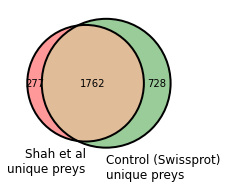

In [162]:
print('Unique preys')
print('Uniprot:', len(set(uniprot_all_preys)), '\nShah:', len(shah_all_preys))
venn([{
    'Shah et al\nunique preys':shah_all_preys,
    'Control (Swissprot)\nunique preys':uniprot_all_preys
}], file_path='ZIKV_figures/uniprot_shah_prey_overlap.svg')

In [163]:
# Count PSMs from parsed reports of proteogenomic run
apms_psms_cnt_customlib = count_psms(apms_psms_customlib, crap)
customlib_all_preys = [x for y in [exp_psms.keys() for exp_id, exp_psms in apms_psms_cnt_customlib.items()] for x in y]
print('interactions:', len(customlib_all_preys), '\nunique preys:', len(set(customlib_all_preys)))
customlib_all_preys = set(customlib_all_preys)

interactions: 12723 
unique preys: 1958


In [164]:
# compare total PSM counts of control and custom runs
all_psms = []
for bait, exp_ids in bait_rep_dict.items():
    for exp_id in exp_ids:
        cust_psms = sum(apms_psms_cnt_customlib[exp_id].values())
        cust_prey_cnt = len(apms_psms_cnt_customlib[exp_id])
        
        ctrl_psms = sum(apms_psms_cnt_uniprot[exp_id].values())
        ctrl_prey_cnt = len(apms_psms_cnt_uniprot[exp_id])
        all_psms.append({
            'bait':bait,
            'cust_psms':cust_psms, 
            'cust_prey_cnt':cust_prey_cnt, 
            'ctrl_psms':ctrl_psms, 
            'ctrl_prey_cnt':ctrl_prey_cnt
        })

print('bait', 'custom', 'uniprot')
for bait, psms in itt.groupby(all_psms, key=lambda x: x['bait']):
    psms = list(psms)
    total_cust_psms = sum([x['cust_psms'] for x in psms])
    total_cust_prey = sum([x['cust_prey_cnt'] for x in psms])
    psms_per_prey_cust = total_cust_psms/total_cust_prey
    
    total_ctrl_psms = sum([x['ctrl_psms'] for x in psms])
    total_ctrl_prey = sum([x['ctrl_prey_cnt'] for x in psms])
    psms_per_prey_ctrl = total_ctrl_psms/total_ctrl_prey
    
    print(bait, psms_per_prey_cust, psms_per_prey_ctrl, psms_per_prey_ctrl>psms_per_prey_cust)

bait custom uniprot
Capsid 11.224975704567541 11.014274691358025 False
NS2B3 8.6610268378063 8.68780487804878 True
NS3 9.12237420615535 8.780792504391957 False
NS4A 8.271153846153846 7.907315561066336 False
NS5 11.943730615861764 11.649079320113314 False


In [165]:
all_preys = set(uniprot_all_preys).union(set(customlib_all_preys)).union(shah_all_preys)

In [167]:
# Build dictionary mapping any protein accession to corresponding uniprot from OP1.6 TSV
prot_acc_to_uniprot = {}
with open('human-openprot-r0_0-refprots+altprots+isoforms-+uniprot2019_03_01.tsv', 'r') as f:
    for n,l in enumerate(f):
        if l[0]=='#': continue
        ls = l.strip().split('\t')    
        if n==1:
            keys = ls
            continue
        line=dict(zip(keys, ls))    
        acc     = line['protein accession numbers'].split('.')[0]
        if is_alt(acc): continue
        acc_syn = line['protein accession (others)'].split(';')
        for p_acc in acc_syn:
            if p_acc in all_preys:
                prot_acc_to_uniprot.update({x:p_acc for x in [acc]+acc_syn})
pickle.dump(prot_acc_to_uniprot, open('prot_acc_to_uniprot.pkl', 'wb'))

In [168]:
detection_cnt = {'ref':0, 'alt':0, 'iso':0, 'zika':0}
for bait, exps in apms_psms_customlib.items():
    for exp_id, psms in exps['exps'].items():
        for protgrp_psms in psms['protgrp_psms_valid_clean'].values():
            for prot_acc, gene in protgrp_psms['prot_accs_genes']:
                detection_cnt[get_tt_type(prot_acc)] += 1
detection_cnt

{'ref': 18258, 'alt': 16, 'iso': 0, 'zika': 0}

## Generate "data" and "key" files for MiST

These files are built according to the MiST article (files are combined into one for the python implementation):  [Verschueren *et al.*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4378866/pdf/nihms-672081.pdf)
([Python implementation](https://github.com/salilab/mist/blob/master/MiST.py))

In [169]:
def write_mist_data(fpath, AP_MS, preys):
    baits = [zikv_bait_files[x] for x in AP_MS.keys()]
    missing_len = []
    n_lines = 0
    with open(fpath, 'w') as f:
        exp_ids = '#\t#\t#\tExps\t'+'\t'.join(list(AP_MS.keys()))+'\n'
        f.write(exp_ids)
        bait_accs = '#\t#\t#\tBaits\t'+'\t'.join(baits)+'\n'
        f.write(bait_accs)
        bait_comp = 'Preys\t#\tLength\t#\t'+'\t'.join(baits)+'\n'
        f.write(bait_comp)
        for prot in preys:
            if 'ZIKV' in prot: continue
            if prot in baits or prot in ('Capsid_Anchor',): continue
            if prot not in prot_lengths:
                missing_len.append(prot)
                continue
            line = '\t'.join([prot, '#', str(prot_lengths[prot]), '#'])
            for exp in AP_MS:
                if prot in AP_MS[exp]:
                    line += '\t' + str(AP_MS[exp][prot])
                else:
                    line += '\t0'
            line += '\n'
            f.write(line)
            n_lines += 1
    print('{} lines written.'.format(n_lines))
    print('missing prot lengths:', missing_len)

In [171]:
write_mist_data('ZIKV_ctrl_mist_data.txt', apms_psms_cnt_uniprot, uniprot_all_preys)

2486 lines written.
missing prot lengths: []


In [173]:
write_mist_data('ZIKV_custom_mist_data.txt', apms_psms_cnt_customlib, customlib_all_preys)

1954 lines written.
missing prot lengths: []


In [174]:
!head -20 ZIKV_custom_mist_data.txt

#	#	#	Exps	qx003992	qx004064	qx004086	qx004220	qx004240	qx004265	qx004297	qx004313	qx004327	qx004012	qx004046	qx004080	qx004218	qx004242	qx004271	qx004014	qx004044	qx004094
#	#	#	Baits	Capsid	Capsid	Capsid	NS4A	NS4A	NS4A	NS5	NS5	NS5	NS3	NS3	NS3	NS3	NS3	NS3	NS2B3	NS2B3	NS2B3
Preys	#	Length	#	Capsid	Capsid	Capsid	NS4A	NS4A	NS4A	NS5	NS5	NS5	NS3	NS3	NS3	NS3	NS3	NS3	NS2B3	NS2B3	NS2B3
Q9H871	#	391	#	0	0	0	0	0	0	3	2	3	0	0	0	0	0	0	0	0	0
P62277	#	151	#	30	32	27	3	7	9	30	29	29	2	3	0	8	8	10	3	3	3
Q9NV31	#	184	#	2	2	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
O43505	#	415	#	0	0	0	3	4	3	0	0	0	1	1	0	0	0	0	1	2	0
O14732	#	288	#	0	0	0	1	2	1	0	0	0	0	0	0	0	1	1	0	0	0
Q96K37	#	410	#	0	0	0	1	1	1	0	0	0	0	2	0	1	0	1	0	2	1
A5YKK6	#	2376	#	0	0	0	0	1	3	0	0	0	1	5	0	9	8	11	1	4	1
P23381	#	471	#	0	0	0	0	1	1	0	0	0	0	0	0	0	1	2	0	0	0
P26373	#	211	#	37	31	44	14	10	14	31	36	34	10	17	15	15	17	16	10	14	8
P09661	#	255	#	6	12	2	0	0	0	6	7	7	0	0	0	0	0	0	0	0	0
O60508	#	579	#	2	1	1	0	0	0	6	3	5	0	0	0	0	0	0	0	0	0
P53597	#	346	#	0	0	0	0	0	0	0	0

## run MiST

In [1]:
print('###\nRun MiST on identifications with Swissprot library (control)\n###')
# flag 1 == remove zeros, flag 0 == don't run PCA (no benchmark, use default weights...)
!python3 mist/MiST.py ZIKV_ctrl_mist_data.txt ZIKV_ctrl 1 0
%cat ZIKV_ctrl.log

###
Run MiST on identifications with Swissprot library (control)
###
(2486, 18)
mist/MiST.py:120: RuntimeWarning: invalid value encountered in true_divide
  protx = TEMP[:,x] / sumx    # normalize per protein in replicates

	*****************************************************************
	*  Welcome to MiST - Mass spectrometry Interaction STatistics   *
	*       written by Peter Cimermancic (Krogan/Sali Lab)          *
	*                           May 2010                            *
	*****************************************************************

Number of Preys: 2486
Number of Experiments: 18
Number of Baits: 5

Thank you for using MiST!


In [2]:
print('\n###\nRun MiST on identifications with custom library (proteogenomics)\n###')
!python3 mist/MiST.py ZIKV_custom_mist_data.txt ZIKV_custom 1 0
%cat ZIKV_custom.log

# this creates files "ZIKV_ctrl_metrics.out" and "ZIKV_custom_metrics.out" that will be parsed after


###
Run MiST on identifications with custom library (proteogenomics)
###
(1954, 18)
mist/MiST.py:120: RuntimeWarning: invalid value encountered in true_divide
  protx = TEMP[:,x] / sumx    # normalize per protein in replicates

	*****************************************************************
	*  Welcome to MiST - Mass spectrometry Interaction STatistics   *
	*       written by Peter Cimermancic (Krogan/Sali Lab)          *
	*                           May 2010                            *
	*****************************************************************

Number of Preys: 1954
Number of Experiments: 18
Number of Baits: 5

Thank you for using MiST!


In [177]:
mist_weights = {
    'Reproducibility' : 0.30853,
    'Abundance' : 0.00596,
    'Specificity' :0.68551,
}

## CompPASS

In [39]:
def write_comppass_input(AP_MS, condition):
    with open('ZIKA_compass_input_{}.csv'.format(condition), 'w') as f:
        writer = csv.writer(f, )
        writer.writerow(('Experiment.ID','Replicate','Experiment.Type','Bait','Prey','Spectral.Count'))
        n_exp = 0
        for exp_id, psms in AP_MS.items():
            n_exp += 1
            bait = rep_bait_dict[exp_id]
            for prey, psm_cnt in psms.items():
                line = (str(n_exp), exp_id, 'True', bait, prey, psm_cnt)
                writer.writerow(line)

In [40]:
write_comppass_input(apms_psms_cnt_uniprot, 'uniprot')

In [41]:
write_comppass_input(apms_psms_cnt_customlib, 'custom')

In [45]:
# CompPASS runs in R ...

In [178]:
def sanitize(s):
    return s.replace('"', '')

def parse_comppass_output(fpath):
    dtypes = {'Experiment.ID':int, 'Bait':sanitize, 'Prey':sanitize, 'AvePSM':float, 'Z':float, 'WD':float, 'Entropy':float}
    comppass_out = []
    with open(fpath, 'r') as f:
        for n,l in enumerate(f):
            fix_commas = {txt_field:txt_field.replace(',', '@') for txt_field in re.findall(r'"([^"]*)"', l) if ',' in txt_field}
            for txt_field in fix_commas:
                l = l.replace(txt_field, fix_commas[txt_field])
            ls = l.strip().split(',')
            if n==0:
                keys = [sanitize(x) for x in ls]
                continue
            line = dict(zip(keys, ls))
            for i in line:
                line[i] = dtypes[i](line[i])
                if i in {'Bait', 'Prey'}:
                    line[i] = line[i].replace('@', ',')
            comppass_out.append(line)

    return comppass_out

In [179]:
def get_net_from_comppass(comppass_output, top_x_percent):
    cnt_prey_per_bait = Counter(x['Bait'] for x in comppass_output)
    compass_hcip = []
    for bait in zikv_baits:
        cutoff = int(cnt_prey_per_bait[bait]*top_x_percent)
        compass_hcip.extend(sorted([x for x in comppass_output if x['Bait']==bait], key=lambda x: -x['WD'])[:cutoff])
    compass_hcip_net = set((x['Bait'], x['Prey']) for x in compass_hcip)
    return compass_hcip_net

In [180]:
def get_comppass_score_dict(comppass_output):
    return {(x['Bait'], x['Prey']):{'WD':x['WD'], 'Z':x['Z']} for x in comppass_output}

In [181]:
comppass_uniprot = parse_comppass_output('ZIKA_compass_output_uniprot.csv')
comppass_custom = parse_comppass_output('ZIKA_compass_output_custom.csv')

In [182]:
uniprot_comppass_score_dict = get_comppass_score_dict(comppass_uniprot)
custom_comppass_score_dict = get_comppass_score_dict(comppass_custom)

## Parse detection statistics results and compare protein interaction sets

### Interactions from Coyaud

In [44]:
!wget https://www.mcponline.org/highwire/filestream/48813/field_highwire_adjunct_files/6/137442_1_supp_164802_pbg7ht.xlsx

--2020-09-16 11:18:25--  https://www.mcponline.org/highwire/filestream/48813/field_highwire_adjunct_files/6/137442_1_supp_164802_pbg7ht.xlsx
Resolving www.mcponline.org (www.mcponline.org)... 104.18.9.131, 104.18.8.131
Connecting to www.mcponline.org (www.mcponline.org)|104.18.9.131|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.mcponline.org/content/mcprot/suppl/2018/07/23/TIR118.000800.DC1/137442_1_supp_164802_pbg7ht.xlsx [following]
--2020-09-16 11:18:26--  https://www.mcponline.org/content/mcprot/suppl/2018/07/23/TIR118.000800.DC1/137442_1_supp_164802_pbg7ht.xlsx
Reusing existing connection to www.mcponline.org:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘137442_1_supp_164802_pbg7ht.xlsx.1’

137442_1_supp_16480     [   <=>              ]   9.43M   569KB/s    in 22s     

2020-09-16 11:18:49 (442 KB/s) - ‘137442_1_supp_164802_pbg7ht.x

count baits: 10 
count unique preys: 696 
count interactions: 1052
Counter({'Capsid': 346, 'NS5': 194, 'NS4B': 84, 'NS1': 83, 'NS4A': 82, 'NS3': 79, 'NS2A': 57, 'NS2B3': 48, 'PreM': 47, 'Env': 32})

keeping only interaction involving baits present in Shah:
count baits shared with Shah: 5 
count unique preys of those baits: 591 
count interactions: 749
Coyaud: 749
Shah: 352
Union of Shah & Coyaud (targets for training): 1062


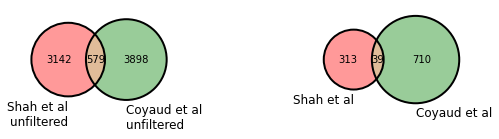

In [48]:
book = pyexcel.get_book(file_name='137442_1_supp_164802_pbg7ht.xlsx')
coyau_s1 = book.to_dict()
coyaud = set()
coyaud_unfiltered = set()
for sheet in ['Summary N-FIP', 'Summary C-FIP']:
    for n, row in enumerate(coyau_s1[sheet]):
        if n==0:
            baits = [x.strip().replace('FlagBirA-', '').replace('-BirAFlag', '').replace('_FIP', '') for x in row if x]
            baits = ['Capsid' if x =='C' else x for x in baits]
            baits = ['NS2B3' if x =='NS2B' else x for x in baits]
            baits_iter1 = (x for x in baits)
            baits_iter2 = (x for x in baits)
        if 'Gene ID' in row:
            keys = [(next(baits_iter1), n) for n, x in enumerate(row) if 'SAINT' in x]
            unflt_keys = [(next(baits_iter2), n) for n, x in enumerate(row) if 'Sum' in x]
        elif row[0]:
            refseq, gene = row[1:3]
            saint = [row[x] for x in [x[1] for x in keys]]
            unflt = [row[x] for x in [x[1] for x in unflt_keys]]
            #r = dict(zip(keys, row))
            hit_baits = [keys[n][0] for n, x in enumerate(saint) if x]
            hit_baits_unflt = [unflt_keys[n][0] for n, x in enumerate(unflt) if x]
            for b in hit_baits:
                # if b not in zikv_baits: continue
                if refseq in prot_acc_to_uniprot:
                    coyaud.add((b, prot_acc_to_uniprot[refseq]))
                else:
                    coyaud.add((b, refseq))
            for b in hit_baits_unflt:
                if refseq in prot_acc_to_uniprot:
                    coyaud_unfiltered.add((b, prot_acc_to_uniprot[refseq]))
                else:
                    coyaud_unfiltered.add((b, refseq))
coyaud_ls = list(coyaud)
print(
    'count baits:', len(set(x[0] for x in coyaud_ls)),
    '\ncount unique preys:', len(set(x[1] for x in coyaud_ls)),
    '\ncount interactions:', len(coyaud)
)
print(Counter([x[0] for x in coyaud_ls]))

print('\nkeeping only interaction involving baits present in Shah:')
coyaud_ls = [x for x in coyaud_ls if x[0] in zikv_baits]
coyaud = set(coyaud_ls)
print(
    'count baits shared with Shah:', len(set(x[0] for x in coyaud_ls)),
    '\ncount unique preys of those baits:', len(set(x[1] for x in coyaud_ls)),
    '\ncount interactions:', len(coyaud)
)

print('Coyaud:', len(coyaud))
print('Shah:', len(shah_net))

targets = shah_net.union(coyaud)
print('Union of Shah & Coyaud (targets for training):', len(targets))

venn([{
    'Shah et al\nunfiltered':shah_unfiltered,
    'Coyaud et al\nunfiltered':coyaud_unfiltered
},{
    'Shah et al':shah_net,
    'Coyaud et al':coyaud
}])

### Score functions

In [184]:
# Score functions
def compute_recall(HCIP, ref_edges_set):
    TP = HCIP.intersection(ref_edges_set)
    FN = ref_edges_set.difference(HCIP)
    return len(TP)/(len(TP) + len(FN))

def compute_precision(HCIP, ref_edges_set):
    TP = HCIP.intersection(ref_edges_set)
    FP = HCIP.difference(ref_edges_set)
    if len(TP) + len(FP) == 0:
        return 0.
    return len(TP)/(len(TP) + len(FP))

def compute_f1(HCIP, ref_edges_set):
    recall    = compute_recall(HCIP, ref_edges_set)
    precision = compute_precision(HCIP, ref_edges_set)
    if recall + precision == 0 :
        return 0.
    return (2 * recall * precision) / (recall + precision)

def score_computer(args):
    thresh, metrics, ref_edges_set, score_thresh = args
    HCIP = set((x['Bait'], x['Prey']) for x in metrics if x[score_thresh]>=thresh)
    recall = compute_recall(HCIP, ref_edges_set)
    precision = compute_precision(HCIP, ref_edges_set)
    fscore = compute_f1(HCIP, ref_edges_set)
    if fscore == 0 :
        return 0.
    return fscore, precision, recall

### Control run

Unfiltered interactions (MiST output)
Uniprot: 12430 
Shah et al, unfiltered: 3721


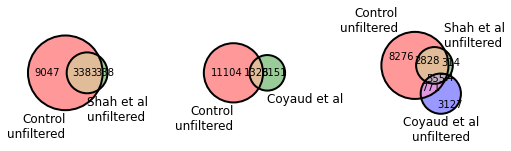

In [185]:
mist_metrics_ctrl = parse_mist_metrics('ZIKV_ctrl_metrics.out', mist_weights)
ctrl_unfiltered = set((x['Bait'], x['Prey']) for x in mist_metrics_ctrl)

print('Unfiltered interactions (MiST output)')
print('Uniprot:', len(ctrl_unfiltered), '\nShah et al, unfiltered:', len(shah_unfiltered))
venn([{
    'Control\nunfiltered':ctrl_unfiltered,
    'Shah et al\nunfiltered':shah_unfiltered
},{
    'Control\nunfiltered':ctrl_unfiltered,
    'Coyaud et al':coyaud_unfiltered
},{
    'Control\nunfiltered':ctrl_unfiltered,
    'Shah et al\nunfiltered':shah_unfiltered,
    'Coyaud et al\nunfiltered':coyaud_unfiltered
}], file_path='ZIKV_figures/uniprot_shah_unfiltered_overlap.svg')

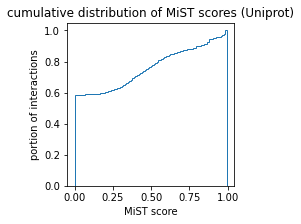

In [186]:
# MiST score distribution
fig, ax = plt.subplots(figsize=(3,3))
ax.set_title('cumulative distribution of MiST scores (Uniprot)')
ax.hist([x['mist_score'] for x in mist_metrics_ctrl], bins=100, cumulative=True, density=True, histtype='step')
ax.set_xlabel('MiST score')
ax.set_ylabel('portion of interactions')
plt.show()

After filtering (MiST score > 0.75) 1501 interactions are obtained, 312 of which are also in the published network.


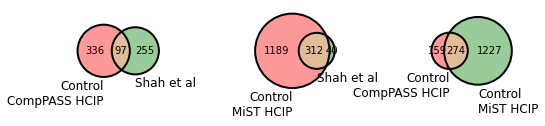

In [187]:
mist_thresh = 0.75
mist_HCIP = set((x['Bait'], x['Prey']) for x in mist_metrics_ctrl if x['mist_score']>mist_thresh)

print('After filtering (MiST score > {}) {} interactions are obtained, {} of which are also in the published network.'.format(
mist_thresh, len(mist_HCIP), len(mist_HCIP.intersection(shah_net))))
# Obtain top 5% interactions from CompPASS 
comppass_HCIP = get_net_from_comppass(comppass_uniprot, 0.05)

venn([{
    'Control\nCompPASS HCIP':comppass_HCIP,
    'Shah et al':shah_net
},{
    'Control\nMiST HCIP':mist_HCIP,
    'Shah et al':shah_net
},{
    'Control\nCompPASS HCIP':comppass_HCIP,
    'Control\nMiST HCIP':mist_HCIP
}])

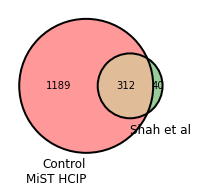

F1 score: 0.3367512142471668
recall: 0.8863636363636364
precision: 0.2078614257161892
lenght MiST HCIP: 1501


In [188]:
venn([{
    'Control\nMiST HCIP':mist_HCIP,
    'Shah et al':shah_net
}], file_path='ZIKV_figures/uniprot_shah_mist_overlap.svg')
print('F1 score:', compute_f1(mist_HCIP, shah_net))
print('recall:', compute_recall(mist_HCIP, shah_net))
print('precision:', compute_precision(mist_HCIP, shah_net))
print('lenght MiST HCIP:', len(mist_HCIP))

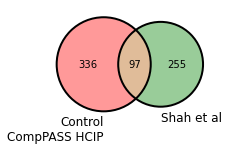

F1 score: 0.24713375796178344
recall: 0.2755681818181818
precision: 0.22401847575057737
lenght MiST HCIP: 433


In [189]:
venn([{
    'Control\nCompPASS HCIP':comppass_HCIP,
    'Shah et al':shah_net
}], file_path='ZIKV_figures/uniprot_shah_compass_overlap.svg')

print('F1 score:', compute_f1(comppass_HCIP, shah_net))
print('recall:', compute_recall(comppass_HCIP, shah_net))
print('precision:', compute_precision(comppass_HCIP, shah_net))
print('lenght MiST HCIP:', len(comppass_HCIP))

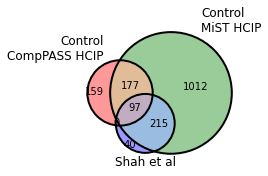

F1 score: 0.3099041533546326
recall: 0.2755681818181818
precision: 0.354014598540146
Count MiST HCIP ∩ CompPASS HCIP: 274


In [191]:
venn([{
    'Control\nCompPASS HCIP':comppass_HCIP,
    'Control\nMiST HCIP':mist_HCIP,
    'Shah et al':shah_net
}], file_path = 'ZIKV_figures/uniprot_shah_mist_compass_overlap.svg')

mist_comppass_HCIP = comppass_HCIP.intersection(mist_HCIP)
print('F1 score:', compute_f1(mist_comppass_HCIP, shah_net))
print('recall:', compute_recall(mist_comppass_HCIP, shah_net))
print('precision:', compute_precision(mist_comppass_HCIP, shah_net))
print('Count MiST HCIP ∩ CompPASS HCIP:', len(mist_comppass_HCIP))

In [192]:
zikv_control_metrics = []
for ppi in mist_metrics_ctrl:
    if not ppi['mist_score'] > 0: continue
    bait_prey = (ppi['Bait'], ppi['Prey'])
    #if bait_prey in uniprot_comppass_score_dict:
    ppi['Z'] = uniprot_comppass_score_dict[bait_prey]['Z']
    ppi['prey_gene'] = get_prey_gene(ppi['Prey'])
    ppi['shared_shah'] = (ppi['Bait'], ppi['Prey']) in shah_net
    zikv_control_metrics.append(ppi)

## Combine detection statistics with Naive Bayes

### Naive Bayes

In [193]:
def NB_score_optimizer(metrics, comppass_scores_dict, return_models=False):    
    metrics = [x for x in metrics if x['mist_score']>0.]
    labels = [1 if (x['Bait'], x['Prey']) in targets else 0 for x in metrics]
    scores = [(x['mist_score'], comppass_scores_dict[(x['Bait'], x['Prey'])]['Z']) for x in metrics]
    
    X = np.array(scores)
    Y = np.array(labels)
    clf = GaussianNB()
    n_splits = 10
    if return_models:
        cv = cross_validate(clf, X, Y, return_estimator=True, cv=n_splits)
        models = cv['estimator']
    accuracy_scores = cross_val_score(clf, X, Y, cv=n_splits)
    Y_pred = cross_val_predict(clf, X, Y, cv=n_splits, method='predict_proba')
    pints = list(Y_pred[:,1])
    for n, i in enumerate(metrics):
        i['nb_score'] = pints[n]
    
    ret_array = [metrics, pints, labels, accuracy_scores]
    if return_models:
        ret_array.append(models)
        
    return ret_array

In [194]:
ZIKV_control_NB, y_pred, t, accuracy_scores = NB_score_optimizer(mist_metrics_ctrl, uniprot_comppass_score_dict)

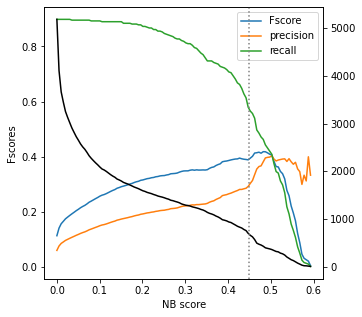

,threshold,Fscore,precision,recall
0,0.482412,0.418485,0.381733,0.463068
1,0.487437,0.418231,0.395939,0.443182
2,0.472362,0.416565,0.364606,0.485795
3,0.467337,0.414692,0.355691,0.497159
4,0.492462,0.414169,0.397906,0.431818


In [196]:
thresholds = np.linspace(0., 1., 200)
args = zip(thresholds, [ZIKV_control_NB,]*len(thresholds), [shah_net,]*len(thresholds), ['nb_score']*len(thresholds))
with Pool(10) as p:
    scores = p.map(score_computer, args)
    
scores = [x for x in scores if type(x)==tuple]
Fscores, precisions, recalls = zip(*scores)
thresholds = thresholds[:len(scores)]

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(thresholds, Fscores, label='Fscore')
ax.plot(thresholds, precisions,  label='precision')
ax.plot(thresholds, recalls, label='recall')
ax.set_xlabel('NB score')
ax.set_ylabel('Fscores')
plt.legend()
counts=[]
for thresh in thresholds:
    counts.append(len(set((x['Bait'], x['Prey']) for x in ZIKV_control_NB if x['nb_score']>thresh)))
ax2 = ax.twinx()
ax2.plot(thresholds, counts, 'k')
plt.axvline(0.45, c='gray', linestyle='dotted')
plt.savefig('ZIKV_figures/uniprot_NB_metrics.svg')
plt.show()
pd.DataFrame(sorted(list(zip(thresholds, Fscores, precisions, recalls)), key=lambda x: -x[1]), columns=['threshold', 'Fscore', 'precision', 'recall']).head(5)

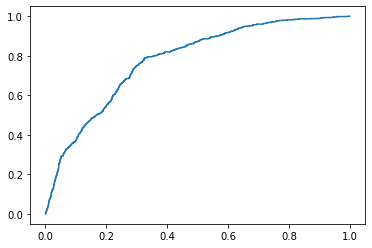

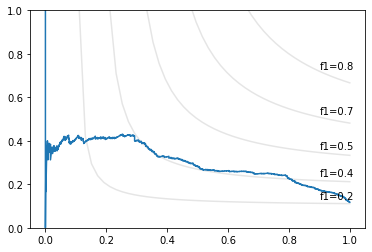

In [197]:
# ROC
fpr, tpr, _ = roc_curve(t, y_pred)
plt.plot(fpr, tpr)
plt.show()

# iso-F1 scores
f_scores = np.linspace(0.2, 0.8, num=5)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

precision, recall, _ = precision_recall_curve(t, y_pred)
plt.plot(recall, precision)
plt.ylim(0,1)
plt.show()

unique preys: 665
After filtering with 10 fold cross-validation 665 interactions are obtained, 199 of which are also in the published network.


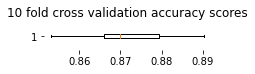

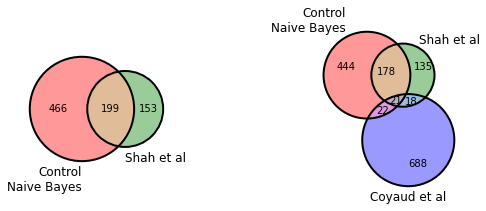

F1 score: 0.3913470993117011
recall: 0.5653409090909091
precision: 0.2992481203007519
Count Naive Bayes HCIP: 665


In [223]:
nb_score_thresh=0.45
ZIKV_ctrl_HCIP = set((x['Bait'], x['Prey']) for x in ZIKV_control_NB if x['nb_score']>nb_score_thresh)

HCIP_preys = set(x[1] for x in ZIKV_ctrl_HCIP)
print('unique preys:', len(HCIP_preys))

HCIP_ctrl_intersection = ZIKV_ctrl_HCIP.intersection(shah_net)
print('After filtering with 10 fold cross-validation {} interactions are obtained, {} of which are also in the published network.'.format(
len(ZIKV_ctrl_HCIP), len(HCIP_ctrl_intersection)))

fig, axs = plt.subplots(figsize=(3,0.5))
axs.set_title('10 fold cross validation accuracy scores')
axs.boxplot(accuracy_scores, vert=False)
plt.box(False)
plt.show()

ZIKV_ctrl_NB_HCIP = [x for x in ZIKV_control_NB if x['nb_score']>nb_score_thresh]
for bp in ZIKV_ctrl_NB_HCIP:
    bp['prey_gene'] = get_prey_gene(bp['Prey'])
    bp['in Shah'] = (bp['Bait'], bp['Prey']) in shah_net
    bp['in Coyaud'] = (bp['Bait'], bp['Prey']) in coyaud
pickle.dump(ZIKV_ctrl_NB_HCIP, open('ZIKV_ctrl_NB_HCIP.pkl', 'wb'))

venn([{
    'Control\nNaive Bayes':ZIKV_ctrl_HCIP,
    'Shah et al':shah_net
},{
    'Control\nNaive Bayes':ZIKV_ctrl_HCIP,
    'Shah et al':shah_net,
    'Coyaud et al':coyaud,
}], file_path='/home/xroucou_group/echange_de_fichiers/Zika_Marie_Seb/figure_pannels/1B_ctrl_shah_venn.svg')
print('F1 score:', compute_f1(ZIKV_ctrl_HCIP, shah_net))
print('recall:', compute_recall(ZIKV_ctrl_HCIP, shah_net))
print('precision:', compute_precision(ZIKV_ctrl_HCIP, shah_net))
print('Count Naive Bayes HCIP:', len(ZIKV_ctrl_HCIP))

We asses the significance of the overlap between sets of edges using a hypergeometric test (Fisher's exact test)

In [82]:
# overlap significance with hypergegometric test
ZIKV_ctrl_only   = len(ZIKV_ctrl_HCIP.difference(shah_net))
shah_only   = len(shah_net.difference(ZIKV_ctrl_HCIP))
intersect = len(ZIKV_ctrl_HCIP.intersection(shah_net))
all_APMS = len(ctrl_unfiltered.union(shah_unfiltered))

# contingency table:
cont_table = [
    [intersect, ZIKV_ctrl_only],
    [shah_only, all_APMS]
]
odds_ratio, pval = stats.fisher_exact(cont_table)

print(odds_ratio, pval)

35.636792055878146 2.745913695131541e-174


In [83]:
fpath = '/home/xroucou_group/echange_de_fichiers/Zika_Marie_Seb/control_scored_ppi.tsv'
with open(fpath, 'w') as f:
    f.write('\t'.join(['Bait', 'Prey', 'Prey Gene', 'MiST', 'CompPASS Z', 'Naive Bayes', 'shared with Shah'])+'\n')
    for ppi in zikv_control_metrics:
        f.write('\t'.join([str(ppi[x]) for x in ['Bait', 'Prey', 'prey_gene', 'mist_score', 'Z', 'nb_score', 'shared_shah']])+'\n')

### Custom

Unfiltered interactions (MiST output)
custom: 9770 
ctrl: 12430


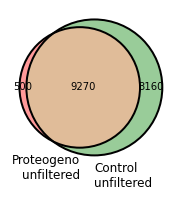

In [270]:
# load MiST ouput
mist_metrics_custom = parse_mist_metrics('ZIKV_custom_metrics.out', mist_weights)
custom_unfiltered = set((x['Bait'], x['Prey']) for x in mist_metrics_custom)
# Split data between altProt and refProt hit (train only using refs)
mist_metrics_noalts = [x for x in mist_metrics_custom if not is_alt(x['Prey'])]
mist_metrics_alts   = [x for x in mist_metrics_custom if is_alt(x['Prey'])]
custom_all_preys = set(x['Prey'] for x in mist_metrics_custom)

print('Unfiltered interactions (MiST output)')
print('custom:', len(custom_unfiltered), '\nctrl:', len(ctrl_unfiltered))
venn([{
    'Proteogeno\nunfiltered':custom_unfiltered,
    'Control\nunfiltered':ctrl_unfiltered
}], file_path='ZIKV_figures/custom_control_unfiltered_overlap.svg')

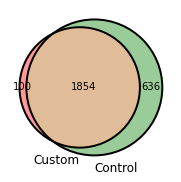

In [274]:
venn([{
    'Custom':custom_all_preys,
    'Control':uniprot_all_preys
}], file_path='ZIKV_figures/custom_control_all_prey.svg')

In [275]:
ZIKV_custom_NB, y_pred, t, accuracy_scores, models = NB_score_optimizer(mist_metrics_noalts, custom_comppass_score_dict, return_models=True)

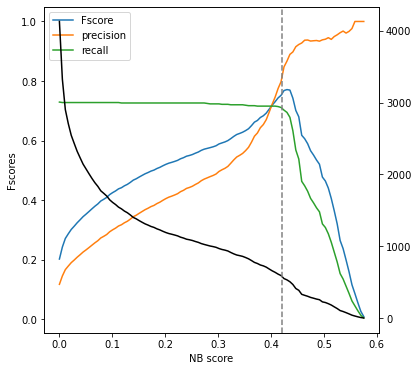

,threshold,Fscores,precision,recall
0,0.430168,0.771285,0.866792,0.694737
1,0.435754,0.769625,0.889546,0.678195
2,0.424581,0.768092,0.847550,0.702256
3,0.418994,0.751987,0.797639,0.711278
4,0.413408,0.743349,0.774878,0.714286


In [276]:
thresholds = np.linspace(0., 1., 180)
n_points = len(thresholds)
args = zip(thresholds, [ZIKV_custom_NB,]*n_points, [ZIKV_ctrl_HCIP,]*n_points, ['nb_score',]*n_points)
with Pool(10) as p:
    scores = p.map(score_computer, args)
    
scores = [x for x in scores if type(x)==tuple]
Fscores, precisions, recalls = zip(*scores)
thresholds = thresholds[:len(scores)]

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(thresholds, Fscores, label='Fscore')
ax.plot(thresholds, precisions,  label='precision')
ax.plot(thresholds, recalls, label='recall')
plt.legend()
ax.set_xlabel('NB score')
ax.set_ylabel('Fscores')
counts=[]
for thresh in thresholds:
    counts.append(len(set((x['Bait'], x['Prey']) for x in ZIKV_custom_NB if x['nb_score']>thresh)))
ax2 = ax.twinx()
ax2.plot(thresholds, counts, 'k')

plt.axvline(0.42, c='gray', linestyle='dashed')
plt.savefig('ZIKV_figures/custom_NB_metrics.svg')

plt.show()
pd.DataFrame(sorted(list(zip(thresholds, Fscores, precisions, recalls)), key=lambda x: -x[1]), columns=['threshold', 'Fscores', 'precision', 'recall']).head(5)

590
After filtering with 10 fold cross-validation 590 interactions are obtained, 159 of which are also in the published network.


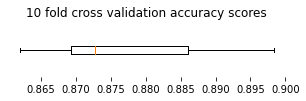

In [277]:
# Custom
nb_score_thresh=0.42
ZIKV_custom_NB_HCIP = set((x['Bait'], x['Prey']) for x in ZIKV_custom_NB if x['nb_score']>nb_score_thresh)

HCIP_preys = set(x[1] for x in ZIKV_custom_NB_HCIP)
print(len(HCIP_preys))

HCIP_custom_intersection = ZIKV_custom_NB_HCIP.intersection(shah_net)
print('After filtering with 10 fold cross-validation {} interactions are obtained, {} of which are also in the published network.'.format(
len(ZIKV_custom_NB_HCIP), len(HCIP_custom_intersection)))

fig, axs = plt.subplots(figsize=(5,1))
axs.set_title('10 fold cross validation accuracy scores')
axs.boxplot(accuracy_scores, vert=False)
axs.get_yaxis().set_visible(False)
plt.box(False)
plt.show()

In [278]:
ZIKV_custom_NB.extend(mist_metrics_alts)

In [279]:
for bp in ZIKV_custom_NB:
    if not bp['mist_score']>0:continue
    z = custom_comppass_score_dict[(bp['Bait'], bp['Prey'])]['Z']
    cv_scores = []
    X = np.array(
        [bp['mist_score'],  z]
    ).reshape(1, -1)
    for model in models:
        cv_scores.append(model.predict_proba(X)[0][1])
    bp['Z'] = z
    bp['nb_score'] = np.mean(cv_scores)
    bp['prey_gene'] = get_prey_gene(bp['Prey'].replace('-', ''))
    bp['shared_Shah'] = (bp['Bait'], bp['Prey']) in shah_net
    bp['shared_Coyaud'] = (bp['Bait'], bp['Prey']) in coyaud
    bp['shared_Uniprot'] = (bp['Bait'], bp['Prey']) in ZIKV_ctrl_HCIP

pickle.dump([x for x in ZIKV_custom_NB if 'nb_score' in x], open('ZIKV_custom_NB.pkl', 'wb'))

print('nb_score_thresh:', nb_score_thresh)
pd.DataFrame(sorted([x for x in ZIKV_custom_NB if 'nb_score' in x if is_alt(x['Prey'])], key=lambda x: -x['nb_score']))

nb_score_thresh: 0.42


,Bait,Prey,Reproducibility,Abundance,Specificity,mist_score,Z,nb_score,prey_gene,shared_Shah,shared_Coyaud,shared_Uniprot
0,NS4A,IP_058843,0.6302,0.0004,1.0000,0.879948,2.748737,0.439691,UBIAD1,False,False,False
1,Capsid,IP_209094,0.6301,0.0005,1.0000,0.879918,2.748737,0.439660,COL2A1,False,False,False
2,Capsid,IP_148668,0.6299,0.0007,1.0000,0.879857,2.748737,0.439597,LOC730101,False,False,False
3,NS4A,IP_086141,0.6218,0.0004,1.0000,0.877356,2.748737,0.437001,ANTXR1,False,False,False
4,NS3,IP_164367,0.3694,0.0007,1.0000,0.799485,2.748737,0.355609,UBXN2B,False,False,False
5,Capsid,IP_789258,0.5906,0.0005,1.0000,0.867731,1.619709,0.329194,RPS3AP38,False,False,False
6,NS5,IP_231479,0.5767,0.0004,0.5669,0.566547,1.257103,0.083140,LPCAT4,False,False,False
7,NS4A,IP_231479,0.6159,0.0003,0.4331,0.486920,1.257103,0.054710,LPCAT4,False,False,False


In [280]:
ZIKV_custom_NB_HCIP = set([(x['Bait'], x['Prey']) for x in ZIKV_custom_NB if 'nb_score' in x and x['nb_score']>0.42])

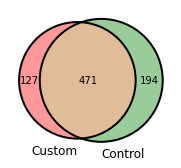

In [281]:
venn([{
    'Custom':ZIKV_custom_NB_HCIP,
    'Control':ZIKV_ctrl_HCIP
}], file_path='ZIKV_figures/custom_control_venn.svg')

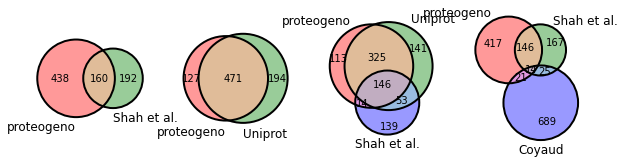

In [284]:
fig, axs = plt.subplots(1,4,figsize=(10,40))

data=[ZIKV_custom_NB_HCIP, shah_net]
venn2(data, set_labels = ('proteogeno', 'Shah et al.'), ax=axs[0])
venn2_circles(data, ax=axs[0])

data=[ZIKV_custom_NB_HCIP, ZIKV_ctrl_HCIP]
venn2(data, set_labels = ('proteogeno', 'Uniprot'), ax=axs[1])
venn2_circles(data, ax=axs[1])

data=[ZIKV_custom_NB_HCIP, ZIKV_ctrl_HCIP, shah_net]
venn3(data, set_labels = ('proteogeno', 'Uniprot', 'Shah et al.'), ax=axs[2])
venn3_circles(data, ax=axs[2])

data=[ZIKV_custom_NB_HCIP, shah_net, coyaud]
venn3(data, set_labels = ('proteogeno', 'Shah et al.', 'Coyaud'), ax=axs[3])
venn3_circles(data, ax=axs[3])
plt.savefig('ZIKV_figures/customlib_venn.svg')
plt.show()